# Load data

In [5]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.io import loadmat
from matplotlib import pyplot as plt

file_path = "../data/laser.mat"
mat_dict = loadmat(file_path)

# mat.items() - displays the dictionary [(),()]

for i, (key, value) in enumerate(mat_dict.items()):
    print(f"key: {key}")

data = mat_dict['X']
target = mat_dict['Y']

# Check the type of the arrays
array_type_data = type(data)
print(f'Type of data: {array_type_data}')

array_type_target = type(target)
print(f'Type of target: {array_type_target}')

# Check numpy array
is_np_array_data = isinstance(data, np.ndarray)
print(f'Data is type of np.ndarray: {is_np_array_data}')

is_np_array_target = isinstance(data, np.ndarray)
print(f'Target is type of np.ndarray: {is_np_array_target}')


key: __header__
key: __version__
key: __globals__
key: X
key: Y
Type of data: <class 'numpy.ndarray'>
Type of target: <class 'numpy.ndarray'>
Data is type of np.ndarray: True
Target is type of np.ndarray: True


# Investigate data

## Dimension

In [6]:

print(f'Shape data: {data.shape}')
print(f'Shape target: {target.shape}')

Shape data: (200, 60)
Shape target: (200, 1)


## Check for missing data

In [7]:
missing_values_data = np.isnan(data)
print(f'Missing values in data: {np.sum(missing_values_data)}')

missing_values_target = np.isnan(target)
print(f'Missing values in target: {np.sum(missing_values_target)}')

Missing values in data: 0
Missing values in target: 0


## Type and range of the values

### 1. Target

In [8]:
target[0:10]

array([[-1],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [ 1],
       [-1],
       [ 1],
       [-1],
       [ 1]], dtype=int16)

In [9]:
unique_values_target, counts_target = np.unique(target, return_counts= True)
print(f'The target vector has the values: {unique_values_target[0]} and {unique_values_target[1]}.')
print(f'The respective occurence per value is: {counts_target}')

The target vector has the values: -1 and 1.
The respective occurence per value is: [100 100]



**Target:** values of -1 or 1

In [10]:
# Calculate Entropy. Result should be 1 bit because 50/50.

### 2. Data

In [11]:
print(data[0])


[29.8509  25.7777  28.8859  30.3456  25.2192  26.2419  25.7909  26.3381
 24.029   24.1634  28.4092  30.86    28.9116  28.0824  28.002   25.5056
 30.4142  25.7292  32.8533  28.8833  28.8396  34.3192  27.1845  34.8657
 28.4742  29.1341  30.4943  34.6255  33.1504  24.5082  24.5538  26.565
 29.993   33.8554   8.14042 14.0027   7.82791  7.85876 10.0092   6.12952
 12.232   10.011   12.1005  14.8451  11.741   11.4403   5.80527 10.0716
  5.59265 16.672   12.9455   6.65538 15.1547  10.5637  10.2817   9.57184
  9.1488   9.65777  5.58567  9.82632]


**Data:** continious values

**Expectation of the behaviour of the data:** As much as possible consistent intensitivity measures over the time period.

#### Sample time series

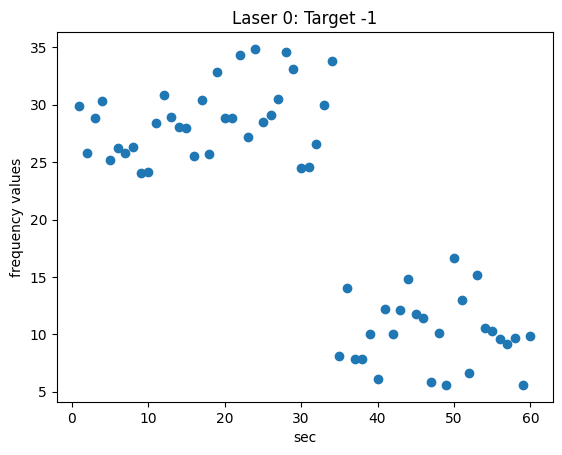

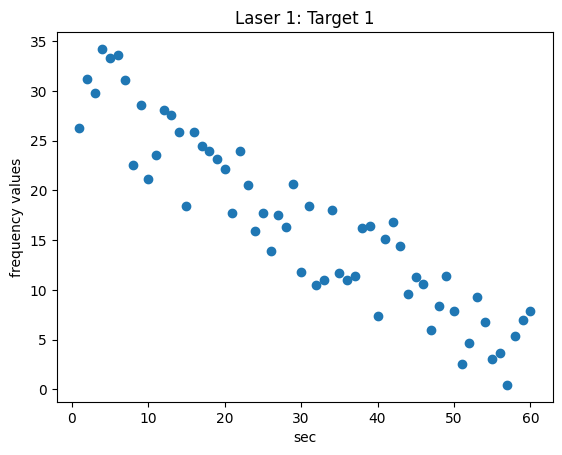

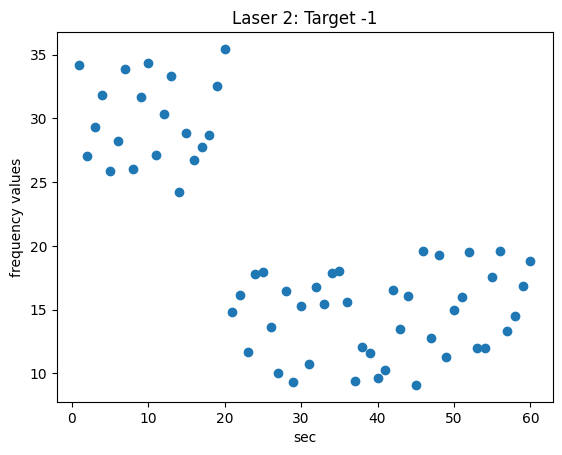

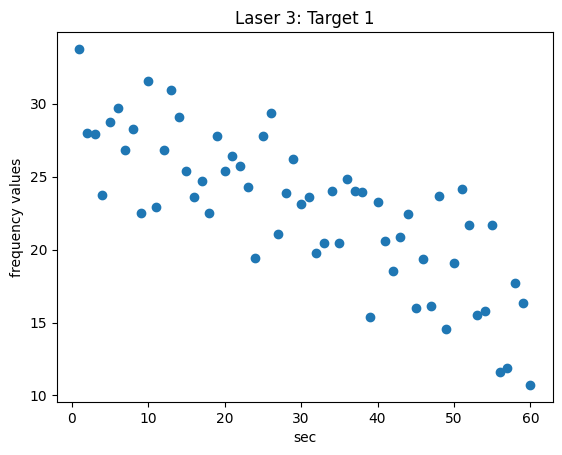

In [12]:
for i in range(0,4):

    laser = data[i, :]
    time_frame = np.arange(1,(len(laser)+1))
    
    plt.scatter(time_frame, laser)
    plt.xlabel('sec')
    plt.ylabel('frequency values')
    plt.title(f"Laser {i}: Target {target[i][0]}")
    plt.show()


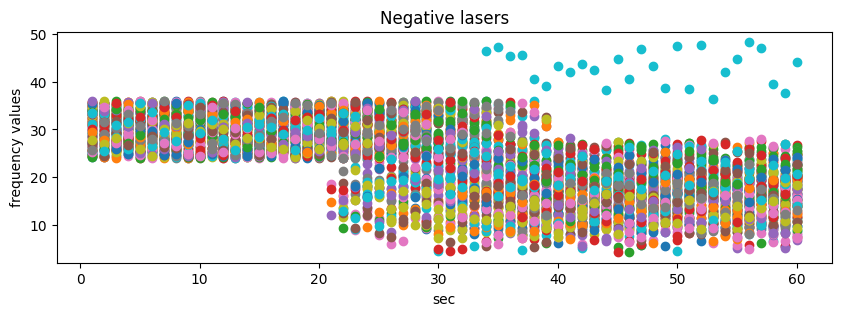

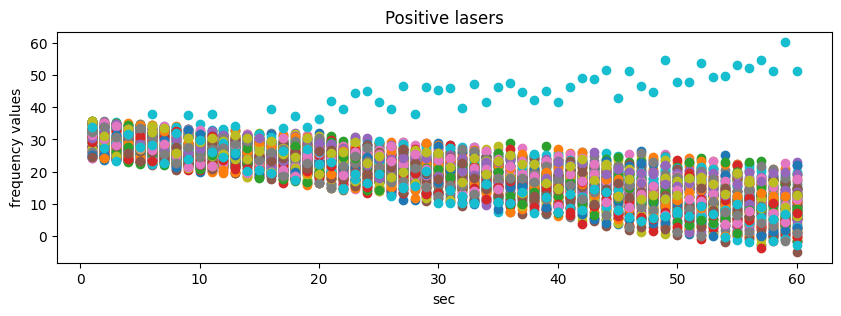

In [13]:
negative_indices = np.where(target < 0)
positive_indices = np.where(target > 0)

negative_lasers = data[negative_indices[0]]
positive_lasers = data[positive_indices[0]]

time_frame = np.arange(1,(len(laser)+1))

plt.figure(figsize=(10, 3))
for i in range(negative_lasers.shape[0]):
    laser_i = negative_lasers[i]
    plt.scatter(time_frame, laser_i, label=f'laser {i}')

plt.title('Negative lasers')
plt.xlabel('sec')
plt.ylabel('frequency values')
plt.show()

plt.figure(figsize=(10, 3))
for i in range(positive_lasers.shape[0]):
    laser_i = positive_lasers[i]
    plt.scatter(time_frame, laser_i, label=f'laser {i}')

plt.title('Positive lasers')
plt.xlabel('sec')
plt.ylabel('frequency values')
plt.show()


#### Min max per row

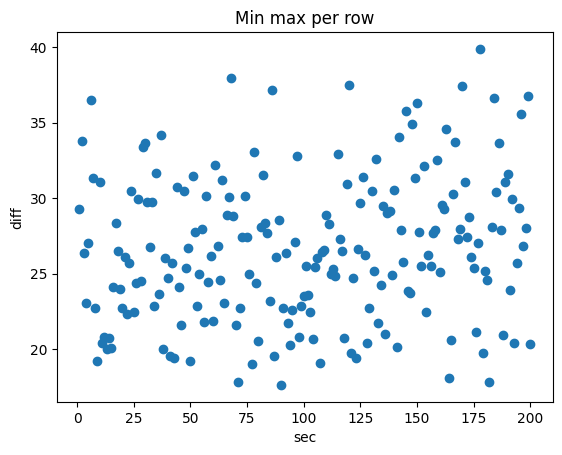

In [14]:
min_values = np.min(data, axis=1)
max_values = np.max(data, axis=1)

difference = max_values - min_values

plt.scatter(np.arange(1,(len(difference)+1)), difference)
plt.xlabel('sec')
plt.ylabel('diff')
plt.title('Min max per row')
plt.show()

#### Varianz per row

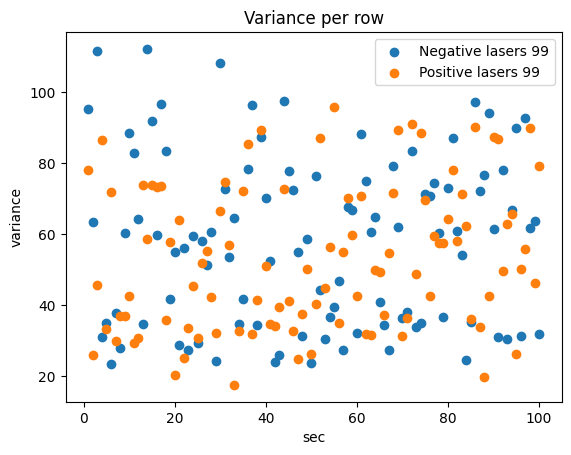

In [15]:
variance_negative = np.var(negative_lasers, ddof=1, axis=1)
variance_positive = np.var(positive_lasers, ddof=1, axis=1)

plt.scatter(np.arange(1,(len(variance_negative)+1)), variance_negative, label=f'Negative lasers {i}')
plt.scatter(np.arange(1,(len(variance_positive)+1)), variance_positive, label=f'Positive lasers {i}')
plt.xlabel('sec')
plt.ylabel('variance')
plt.title('Variance per row')
plt.legend()
plt.show()


#### Min max per column

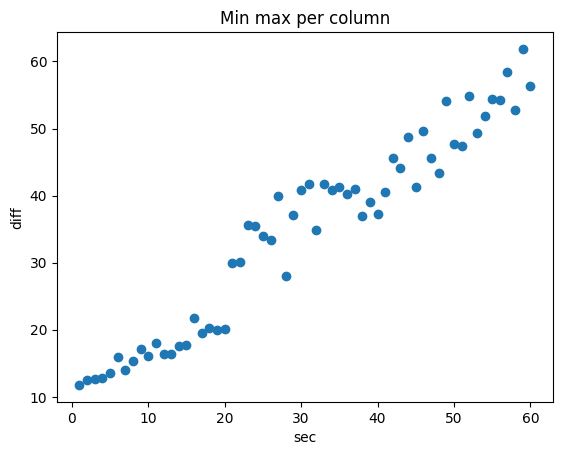

In [16]:
min_values = np.min(data, axis=0)
max_values = np.max(data, axis=0)

difference = max_values - min_values

plt.scatter(np.arange(1,(len(difference)+1)), difference)
plt.xlabel('sec')
plt.ylabel('diff')
plt.title('Min max per column')
plt.show()